In [2]:
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torchvision
import math
import time

In [3]:
cifar10 = load_dataset('cifar10')

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
def img_to_tensor(im):
  return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

# The Forward Diffusion Process

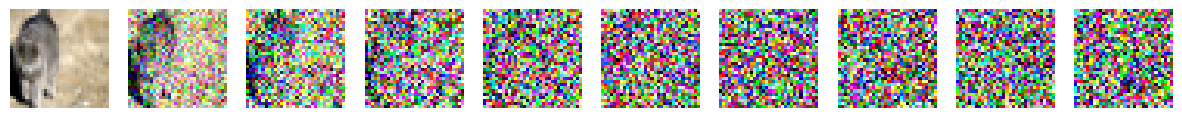

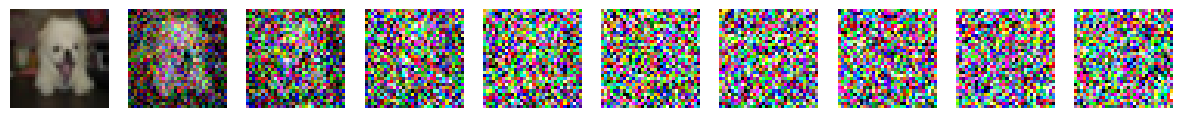

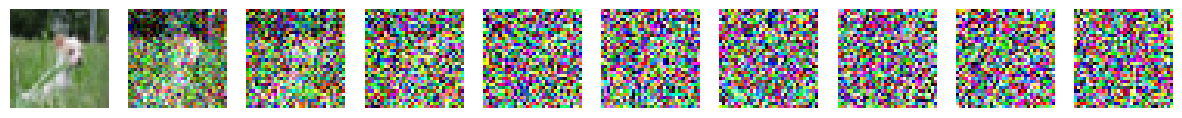

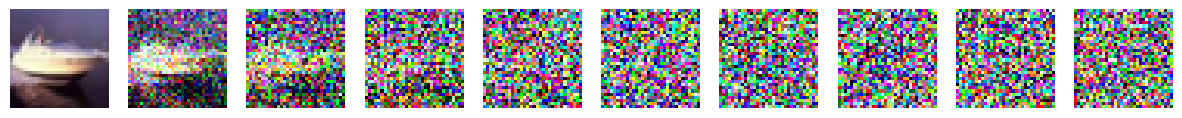

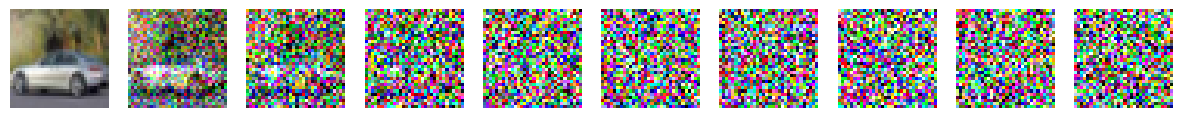

In [5]:
n_steps = 1000
beta = torch.linspace(0.0001, 0.04, n_steps)

def q_xt_xtminus1(xtm1, t):
    Beta_t = beta[t]
    mean = torch.sqrt(1 - Beta_t) * xtm1
    q_xt_xtminus1 = mean + torch.sqrt(Beta_t) * torch.distributions.Normal(0, 1).sample(mean.shape)
    return q_xt_xtminus1

for i in range(5):
  ims = []
  start_im = cifar10['train'][i+15]['img']
  x = img_to_tensor(start_im).squeeze()
  for t in range(n_steps):
    if t % 100 == 0:
      ims.append(tensor_to_image(x))
    t = torch.tensor(t, dtype=torch.long)
    x = q_xt_xtminus1(x, t)
  fig, axs = plt.subplots(1, len(ims), figsize=(15, 3))
  for i, im in enumerate(ims):
    axs[i].imshow(im)
    axs[i].axis('off')
  plt.show()

Since we want to train our model at different time steps use of betas is not efficient. So we use a trick using alphas. Where alpha is 1-beta. and alpha_bar is basically a **cumulative product** of alphas.For example t=8, a8= a1.a2.a3.a4.a5.a6.a7.a8. This alpha_bar lets us train at different time steps

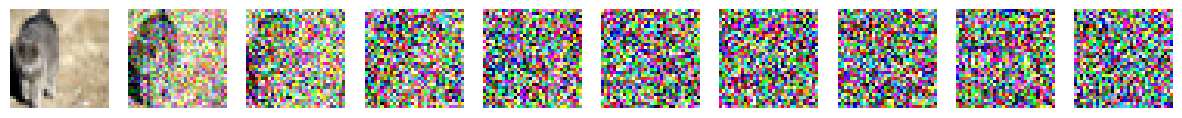

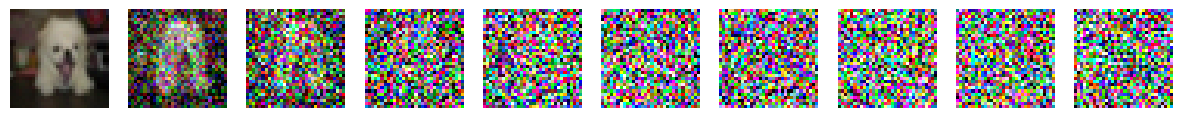

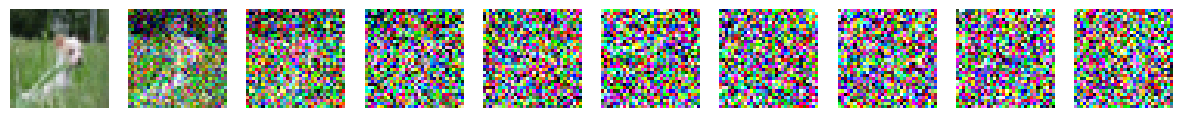

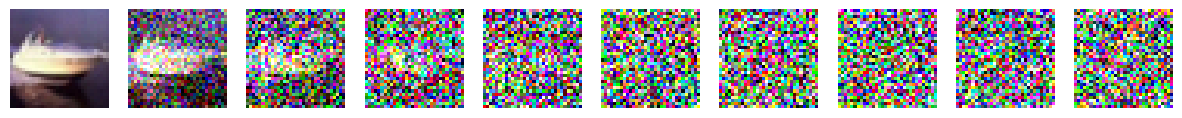

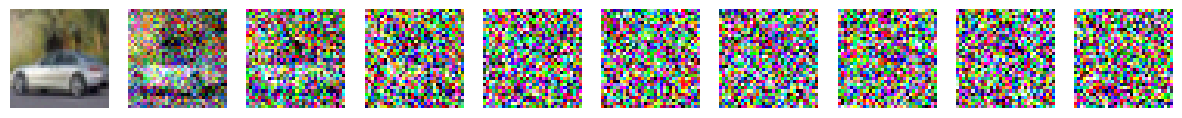

In [7]:
n_steps = 1000
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):

    alpha_bar_t = alpha_bar[t]
    mean = torch.sqrt(alpha_bar_t)*x0
    q_xt_x0 = mean + torch.sqrt(1-alpha_bar_t) * torch.distributions.Normal(0, 1).sample(mean.shape)

    return q_xt_x0

for i in range(5):
  ims = []
  start_im = cifar10['train'][i+15]['img']
  x0 = img_to_tensor(start_im).squeeze()
  for t in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]:
    x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long)) 
    ims.append(tensor_to_image(x))

  fig, axs = plt.subplots(1, len(ims), figsize=(15, 3))
  for j, im in enumerate(ims):
      axs[j].imshow(im)
      axs[j].axis('off')
  plt.savefig(f'/kaggle/working/output_img_forward_{i+1}.png')
  plt.show()

# The Model

In [8]:
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)

In [9]:
class TimeEmbedding(nn.Module):

    def __init__(self, n_channels: int):

        super().__init__()
        self.n_channels = n_channels
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        self.act = Swish()
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):

        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)


        return emb

In [10]:
class AttentionBlock(nn.Module):

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):

        super().__init__()

        if d_k is None:
            d_k = n_channels
        self.norm = nn.GroupNorm(n_groups, n_channels)
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        self.output = nn.Linear(n_heads * d_k, n_channels)
        self.scale = d_k ** -0.5
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor):

        batch_size, n_channels, height, width = x.shape
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)

        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        attn = attn.softmax(dim=1)
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        res = self.output(res)

        res = res + x

        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        return res

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels):
        super(ConvBlock, self).__init__()
        self.norm1 = nn.GroupNorm(32, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(32, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x, t):
        x = self.conv1(self.act1(self.norm1(x)))
        x = x + self.time_emb(t)[:, :, None, None]
        x = self.conv2(self.act2(self.norm2(x)))
        return x

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels):
        super(ResidualBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels, time_channels)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
        
            )
        else:
            self.shortcut = nn.Sequential(
                nn.Identity()
            )

    def forward(self, x, t):
        return self.conv_block(x,t) + self.shortcut(x)

In [13]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels, has_attn: bool):
        super(EncoderBlock, self).__init__()
        self.res_block = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()
        self.res_block2 = ResidualBlock(out_channels, out_channels, time_channels)
        if has_attn:
            self.attn2 = AttentionBlock(out_channels)
        else:
            self.attn2 = nn.Identity()
        #self.pool = nn.MaxPool2d(2)
        self.conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x, t):
        x = self.res_block(x,t)
        x = self.attn(x)
        x = self.res_block2(x,t)
        x = self.attn2(x)
        #p = self.pool(x)
        p = self.conv(x)
        return x, p

In [14]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, time_channels, has_attn: bool):
        super(DecoderBlock, self).__init__()
        #self.up = nn.ConvTranspose2d(in_channels, middle_channels, kernel_size=2, stride=2)
        self.up = nn.ConvTranspose2d(in_channels, middle_channels, kernel_size=4, stride=2, padding=1)
        self.res_block = ResidualBlock(middle_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()
        self.res_block2 = ResidualBlock(out_channels, out_channels, time_channels)
        if has_attn:
            self.attn2 = AttentionBlock(out_channels)
        else:
            self.attn2 = nn.Identity()

    def forward(self, x, skip, t):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.res_block(x,t)
        x = self.attn(x)
        x = self.res_block2(x,t)
        x = self.attn2(x)
        return x

In [15]:
class ResidualAttUNet32(nn.Module):
    def __init__(self):
        super(ResidualAttUNet32, self).__init__()
        self.time_emb = TimeEmbedding(64 * 4)
        self.start = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 32
        self.encoder1 = EncoderBlock(32, 32, 64 * 4, False)  # 32,32
        self.encoder2 = EncoderBlock(32, 64, 64 * 4, False)  # 32,64
        self.encoder3 = EncoderBlock(64, 128, 64 * 4, True)  # 64,128
        self.encoder4 = EncoderBlock(128, 512, 64 * 4, True)  #128,512

        self.bridge = ResidualBlock(512, 512, 64 * 4) #512,512
        self.att = AttentionBlock(512)
        self.bridge2 = ResidualBlock(512, 512, 64 * 4) #512,512

        self.decoder1 = DecoderBlock(512, 512, 512, 64 * 4, True) # 512
        self.decoder2 = DecoderBlock(512, 128, 128, 64 * 4, True) 
        self.decoder3 = DecoderBlock(128, 64, 64, 64 * 4, False)
        self.decoder4 = DecoderBlock(64, 32, 32, 64 * 4, False)

        self.norm = nn.GroupNorm(8, 32)
        self.act = Swish()
        self.final = nn.Conv2d(32, 3, kernel_size=1)

    def forward(self, x, t):
        t = self.time_emb(t)
        x = self.start(x) # relu is inside the residual block
        s1, p1 = self.encoder1(x,t)
        s2, p2 = self.encoder2(p1,t)
        s3, p3 = self.encoder3(p2,t)
        s4, p4 = self.encoder4(p3,t)

        b = self.bridge(p4,t)
        b = self.att(b)
        b = self.bridge2(b,t)

        d1 = self.decoder1(b, s4, t)
        d2 = self.decoder2(d1, s3, t)
        d3 = self.decoder3(d2, s2, t)
        d4 = self.decoder4(d3, s1, t)

        output = self.final(self.act(self.norm(d4)))
        return output

In [16]:
unet = ResidualAttUNet32().cuda()

n_steps = 1000
beta = torch.linspace(0.0001, 0.04, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):

    eps=torch.randn(x0.shape).cuda()
    alpha_bar_t = alpha_bar[t-1]
    xt = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1-alpha_bar_t) * eps
    return xt , eps


def calc_loss(unet: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    t=torch.randint(1,n_steps,(len(x),1,1,1)).cuda()
    x_t,eps = q_xt_x0(x,t)
    t=t.reshape(len(x),)
    eps_t = unet(x_t,t)
    loss = F.mse_loss(eps_t, eps)
    return loss

In [17]:
batch_size = 128
lr = 1e-4
optim = torch.optim.AdamW(unet.parameters(), lr=lr)

In [18]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())

100%|██████████| 170498071/170498071 [00:04<00:00, 42234748.18it/s]


Extracting data/cifar-10-python.tar.gz to data/


1 (60.88360643386841s): 0.0888487845659256
2 (120.32028293609619s): 0.04123494401574135
3 (179.80043530464172s): 0.046598564833402634
4 (239.27979063987732s): 0.024897655472159386
5 (298.76204013824463s): 0.03857763856649399
6 (358.23856258392334s): 0.02705216594040394
7 (417.7179868221283s): 0.01900162734091282
8 (477.22530245780945s): 0.028577549383044243
9 (536.734050989151s): 0.031002361327409744
10 (596.2593553066254s): 0.023364875465631485
11 (655.7564866542816s): 0.032626762986183167
12 (715.2464108467102s): 0.019171126186847687
13 (774.7312998771667s): 0.025564927607774734
14 (834.2532141208649s): 0.043650589883327484
15 (893.7395899295807s): 0.04476020857691765
16 (953.2153825759888s): 0.03155825287103653
17 (1012.7385478019714s): 0.018968841060996056
18 (1072.3067259788513s): 0.04511842131614685
19 (1131.8556036949158s): 0.014048533514142036
20 (1191.3467302322388s): 0.029044801369309425
21 (1250.83749127388s): 0.025542763993144035
22 (1310.3227427005768s): 0.0255683176219463

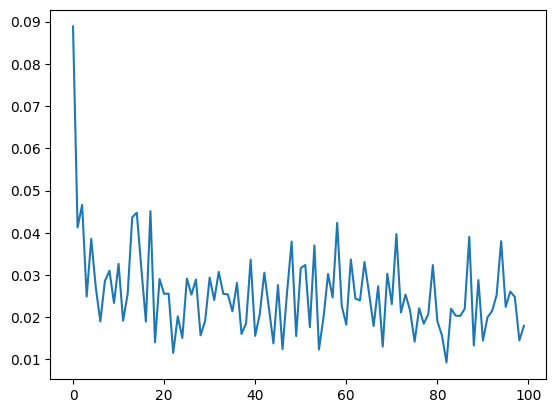

In [19]:
data_loader=torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
t0 = time.time()
losses = []
for i_epoch in range (100) :
    total_loss = 0
    for data in data_loader:
        optim.zero_grad()
        loss = calc_loss(unet,(2*data[0]-1).cuda())
        loss.backward()
        optim.step()

    print(f"{i_epoch+1} ({time.time() - t0}s): {loss.item()}")
    losses.append(loss.item())
plt.plot(losses)

# CIFAR-10 Progressive Generation - The Reverse Process

In [20]:
def p_xt(xt, noise, t):

    alpha_t = alpha[t-1]
    alpha_bar_t = alpha_bar[t-1]
    if t>1:
      z = torch.randn(xt.shape).cuda()
    else:
      z = torch.zeros(xt.shape).cuda()
    sigma_t = torch.sqrt(beta[t-1])
    x_tm1 = (  xt - ( noise*(1-alpha_t)/torch.sqrt(1-alpha_bar_t) )  ) / (torch.sqrt(alpha_t))  + sigma_t*z
    return x_tm1

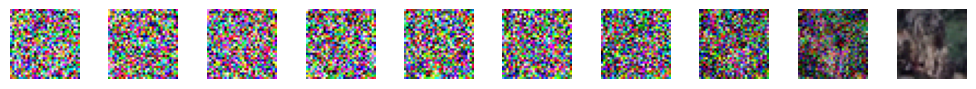

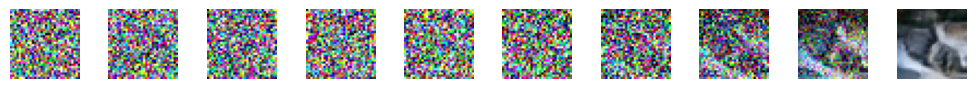

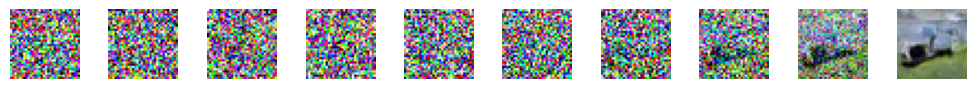

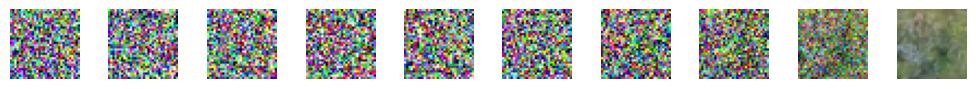

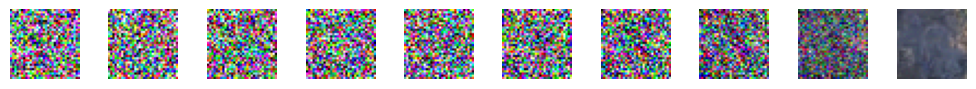

In [24]:
for i in range(5):
    x = torch.randn(1, 3, 32, 32).cuda()
    imsx = []

    for j in range(n_steps):
      t = torch.tensor(n_steps-j-1, dtype=torch.long).cuda()
      with torch.no_grad():
        pred_noise = unet(x.float(), t.unsqueeze(0))
        x = p_xt(x, pred_noise, t.unsqueeze(0))
        if t%100 == 0:
            imsx.append(tensor_to_image(x.unsqueeze(0).cpu()))

    num_images = len(imsx)
    cols = 10
    rows = 1
    plt.figure(figsize=(cols, rows))
    for k, im in enumerate(imsx):
        plt.subplot(rows, cols, k + 1)
        plt.imshow(im)
        plt.axis('off')
    plt.tight_layout()
    #plt.savefig(f'/kaggle/working/reverse_img_{i+1}.png')
    plt.show()

A closer look at last 500 time steps for more clear visibility of progressive generation

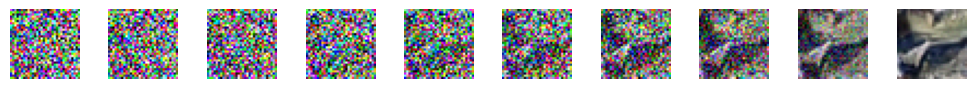

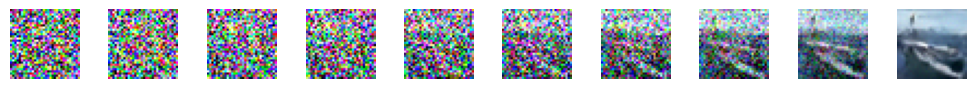

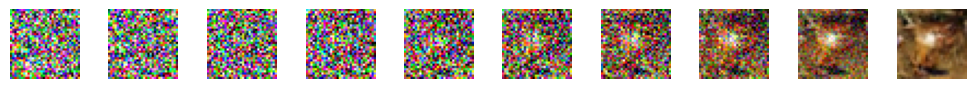

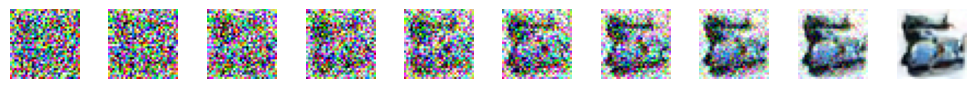

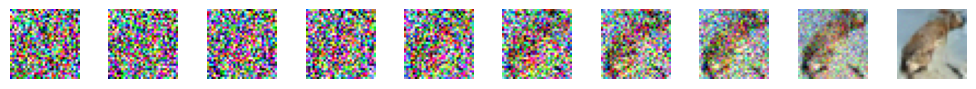

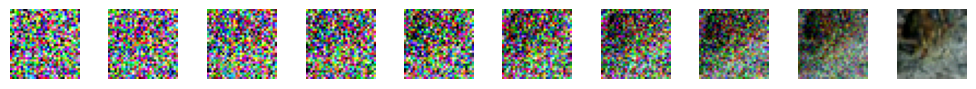

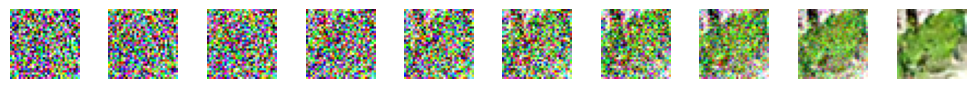

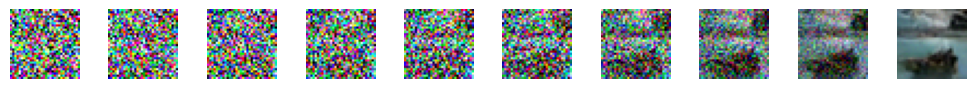

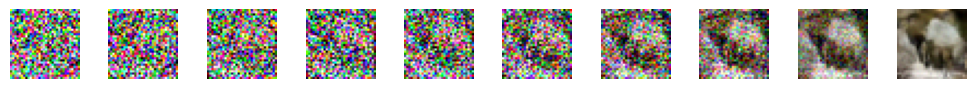

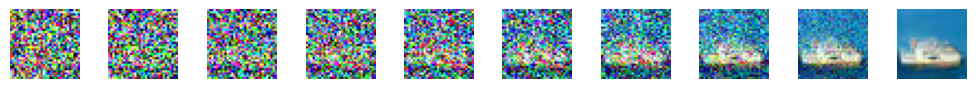

In [25]:
for i in range(10):
    x = torch.randn(1, 3, 32, 32).cuda()
    imsx = []

    for j in range(n_steps):
      t = torch.tensor(n_steps-j-1, dtype=torch.long).cuda()
      with torch.no_grad():
        pred_noise = unet(x.float(), t.unsqueeze(0))
        x = p_xt(x, pred_noise, t.unsqueeze(0))
        if t < 500 and t % 50 == 0:
            imsx.append(tensor_to_image(x.unsqueeze(0).cpu()))

    num_images = len(imsx)
    cols = 10
    rows = 1
    plt.figure(figsize=(cols, rows))
    for k, im in enumerate(imsx):
        plt.subplot(rows, cols, k + 1)
        plt.imshow(im)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/reverse_img_{i+1}.png')
    plt.show()

# Sampled Images

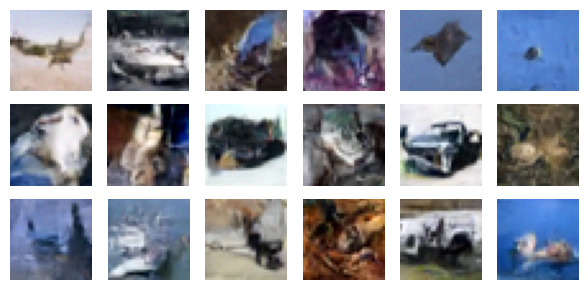

In [27]:
x = torch.randn(18, 3, 32, 32).cuda()
ims = []

for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))
    
#print(len(x))
for i in range(18):
    ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))
    
num_images = len(ims)
cols = 6 
rows = 3
plt.figure(figsize=(cols, rows))
for i, im in enumerate(ims):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()
plt.savefig(f'/kaggle/working/sampled_images.png')
plt.show()